==============================================================================================
## Practicum 5: Image search using textures


==============================================================================================



The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline (Campus Virtual): December 8th, 23:00 h**


 The function should return a feature vector obtained by averaging each filter response on the image.  

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [2]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
import os
from skimage.transform import resize

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Resize dimension 250 x 250
x = 250
y = 250

path = "./images/texturesimages/pizza/"                       
pizza_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]

path = "./images/texturesimages/fish_and_chips/"
fishandchips_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]

path = "./images/texturesimages/paella/"
paella_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]

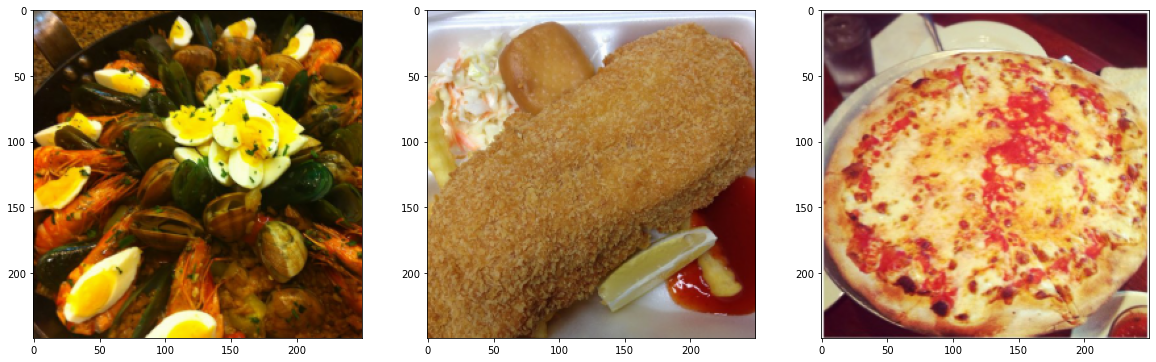

In [4]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(paella_images[0])
ax[1].imshow(fishandchips_images[0])
ax[2].imshow(pizza_images[0])
plt.show()

In [5]:
len(paella_images), len(fishandchips_images), len(pizza_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [6]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [7]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

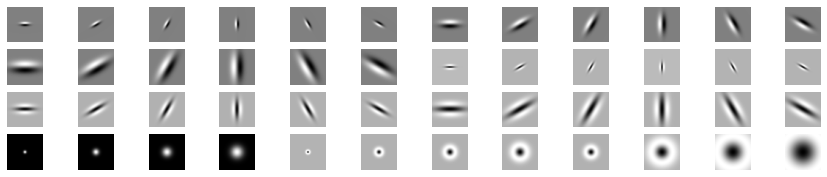

In [8]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


## Exercise 5.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >


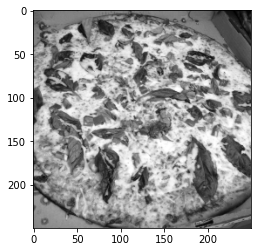

In [15]:
im = pizza_images[5]
im = skimage.color.rgb2gray(im)
plt.imshow(im, cmap="gray")

In [16]:
# Function that will show n images in a row
# Can be added titles to images
# Show in gray levels
# Size by default will be (15,15)
def show_images(images, titles = None, is_gray = True, size=(15,15)):
    %matplotlib inline
    # Create the struct
    fig, ax = plt.subplots(1, len(images), figsize=size)
    
    for i in range(len(images)):        
        # Adding original image
        if is_gray:
            ax[i].imshow(images[i], cmap='gray')
        else:
            ax[i].imshow(images[i])
        # Adding title
        if not titles == None :            
            ax[i].set_title(titles[i])    
        # Removing axis
        ax[i].axis('off')
    
    # Show the result
    plt.show()

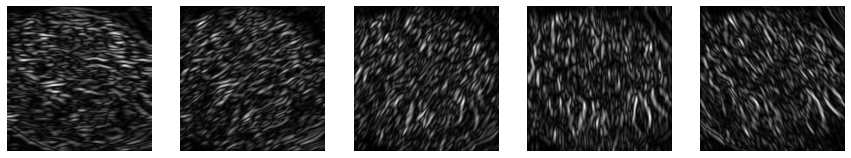

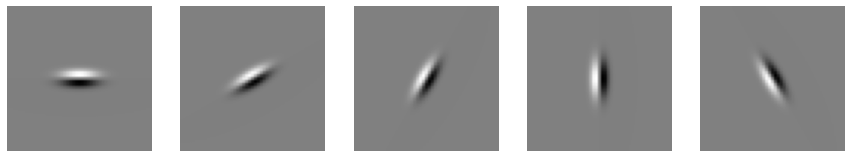

In [17]:
# Function that visualize the features from an image
def visualize_features(im,  filter_bank, n_filters=5):    
    # List where result will be stored
    res_filters = []
    filters_applied = []
    
    for i in range(n_filters):
        actual_filter = i        
        # Create a result image
        res = np.zeros(im.shape)
        # Select the mask from actual filter
        mask = filter_bank[:,:,actual_filter]
    
        # Convolve the image with the mask
        scipy.ndimage.convolve(im, mask, output=res)
        
        # Put every result with absoulute numbers in the list
        res_filters.append(np.abs(res))
        
        # Also put the mask applied
        filters_applied.append(mask)
    
    # Print all the list
    show_images(res_filters)
    show_images(filters_applied)

visualize_features(im, filter_bank)


## Exercise 5.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [18]:
im = skimage.color.rgb2gray(pizza_images[0])

# Get all the features from all filters
def features_from_filter_bank(image, filter_bank, n_filters):
    # List where features will be stored
    features_for_im = np.zeros(n_filters)
    
    for i in range(n_filters):
        actual_filter = i                
        # Select the mask from actual filter
        mask = filter_bank[:,:,actual_filter]

        # Convolve the image with the mask
        # Make an absolute result, get the mean and store it
        features_for_im[i] = np.mean(abs(scipy.ndimage.convolve(image, mask)))                
    
    return features_for_im

features_for_im = features_from_filter_bank(im, filter_bank, n_filters)

## Exercise 5.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [12]:
all_images = pizza_images + fishandchips_images + paella_images

In [13]:
%%time

def get_class_features(all_images,  filter_bank):
    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors = np.zeros((n_images,filter_bank.shape[-1]))
    # Complete
    
    # n_images corresponds to the number of rows of the resulting array
    # For each image in our set of images
    for i in range(n_images):
        # We pass the image to gray
        image = skimage.color.rgb2gray(all_images[i])        
        # We get its feature vector (with the mean of the absolute value of the 
        # convolved image for each filter from our filter_bank)
        all_feature_vectors[i] = features_from_filter_bank(image, filter_bank, n_filters)        
            
    # We return the all_feature_vectors matrix
    return all_feature_vectors

all_feature_vectors = get_class_features(all_images,  filter_bank)

Wall time: 13min 22s


In [16]:
print(all_feature_vectors)

[[0.0172559  0.01644058 0.01479478 ... 0.11733988 0.0372714  0.00282648]
 [0.01005518 0.01068532 0.01122815 ... 0.14770367 0.04691604 0.00324634]
 [0.02171766 0.01964706 0.01623778 ... 0.15197135 0.04827161 0.00381521]
 ...
 [0.01941687 0.01753698 0.01602435 ... 0.09225833 0.02930459 0.0034459 ]
 [0.01543341 0.01457694 0.01304391 ... 0.15187818 0.04824201 0.00364771]
 [0.01778494 0.01607745 0.0136981  ... 0.13772458 0.04374632 0.00328898]]


## Exercise 5.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


In [14]:
def visualize_features(k, all_feature_vectors):
    # complete
    return None

visualize_features(25, all_feature_vectors)    
visualize_features(41, all_feature_vectors)    





#### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$


## Exercise 5.5 Retrieving the most similar images



Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar images (according to the l2 norm) and the distances from the closest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

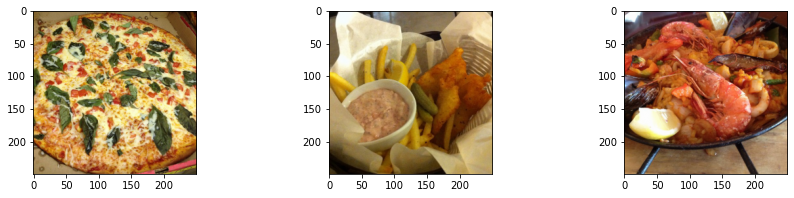

In [15]:
X = np.array(all_feature_vectors)
ind_1 = 10
ind_2 = 40
ind_3 = 70

query_1 = X[10, :]
query_2 = X[40,:]
query_3 = X[70,:]


# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[10]) 
ax[1].imshow(all_images[40])
ax[2].imshow(all_images[70])

In [16]:
# Returns k images that are closes to the query image
def retrieve_k_images_from_X(query, X, k):
    # List where distances will be store
    distances = []    
    closest_images = []            
    
    # Iterate over an enumerate to save the index
    for i, image in enumerate(X):         
        # Calculate distance   
        distance = np.sqrt(np.sum((query - image)**2))        
        # Save the images that are not equal to query, because query image are in the dataset X
        if distance != 0.0:
            distances.append((i, distance))
            closest_images.append((i, distance))
    # Sort by distance
    closest_images.sort(key=lambda x: x[1])    
    # Returning k images 
    return closest_images[:k], distances

In [70]:
# Return the closests images
def get_images(images, k):
    res = []
    for i in range(k):
        res.append(all_images[images[i][0]])        
    return res
# Return titles from the closests images with their distances
def get_titles(images, k):
    res = []
    for i in range(k):
        res.append('Index: ' + str(images[i][0]) +'Distance :' + str(images[i][1]))
        
    return res

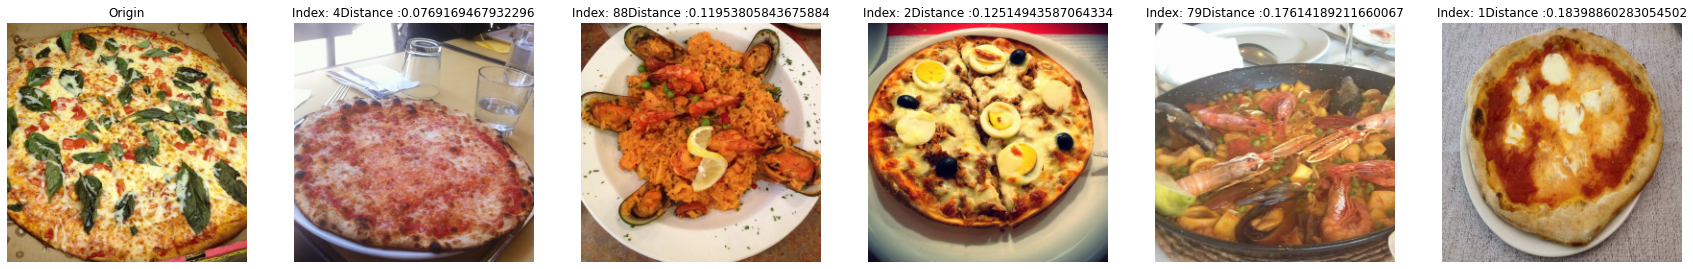

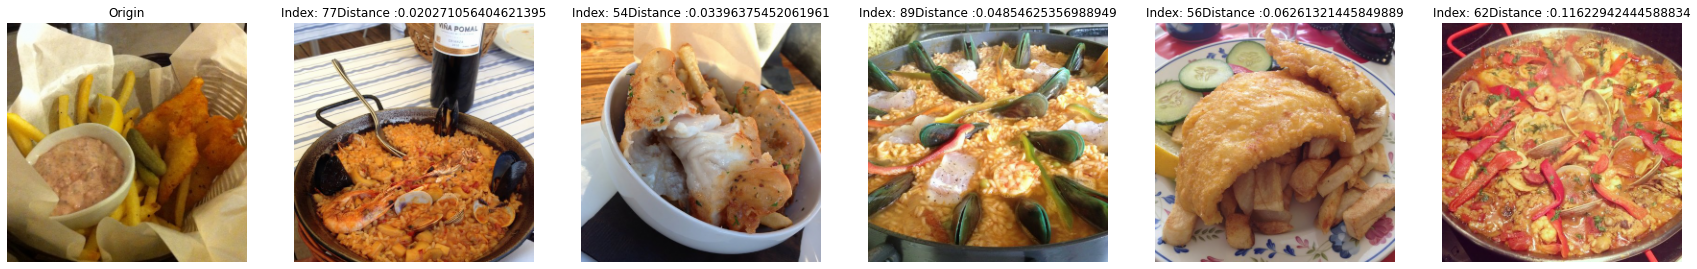

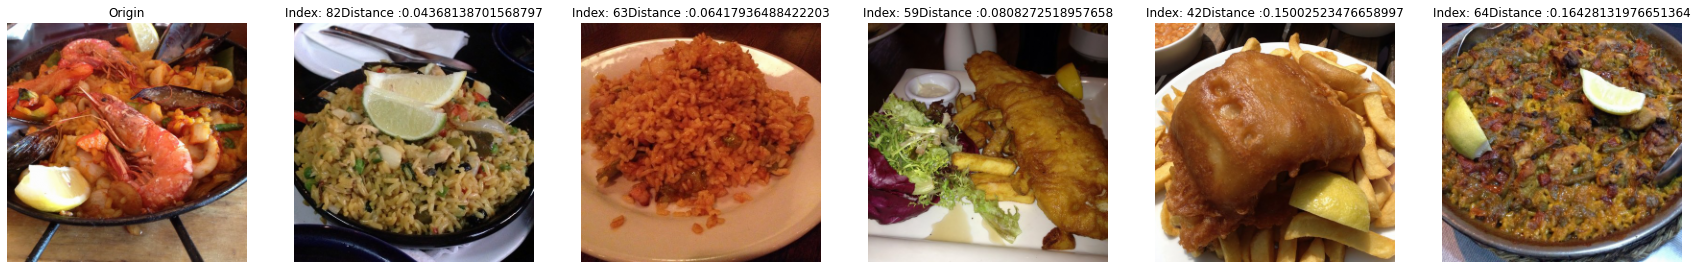

In [71]:
k = 5

# Get data from each query
images_q1, distances_q1 = retrieve_k_images_from_X(query_1, X, k)
# Get images
images = [all_images[ind_1]] + get_images(images_q1, k)
# Get titles
title = ['Origin'] + get_titles(images_q1, k)
# Plot results
show_images(images, title, is_gray = True, size = (30,30))

images_q2, distances_q2 = retrieve_k_images_from_X(query_2, X, k)
# Get images
images = [all_images[ind_2]] + get_images(images_q2, k)
# Get titles
title = ['Origin'] + get_titles(images_q2, k)
# Plot results
show_images(images, title, is_gray = True, size = (30,30))

images_q3, distances_q3 = retrieve_k_images_from_X(query_3, X, k)
# Get images
images = [all_images[ind_3]] + get_images(images_q3, k)
# Get titles
title = ['Origin'] + get_titles(images_q3, k)
# Plot results
show_images(images, title, is_gray = True, size = (30,30))

## Exercise 5.6 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.

- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?


In [29]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

In [81]:
# Retuns an accuracy from the closests images, there will be a match if they are in the same class
def accuracy(X, class_labels, k, query, class_query):
    # Get images
    images_q, distances = retrieve_k_images_from_X(query, X, k)
    
    # Match counter
    match_counts = 0
    for i in range(k):        
        # Get index from closest image
        index = images_q[i][0]        
        # Get her class
        image_class = class_labels[index]        
        # Compare
        if image_class == class_query:            
            match_counts += 1
            
    return match_counts / k

In [86]:
k = 4
# Get each query
query_1 = X[ind_1, :]
query_2 = X[ind_2,:]
query_3 = X[ind_3,:]

# Comentar las preguntas

# Show all acurracies
print('Accuracy Query 1', accuracy(X, class_labels, k, query_1, class_labels[ind_1]))

print('Accuracy Query 2', accuracy(X, class_labels, k, query_2, class_labels[ind_2]))

print('Accuracy Query 3', accuracy(X, class_labels, k, query_3, class_labels[ind_3]))

Accuracy Query 1 0.5
Accuracy Query 2 0.5
Accuracy Query 3 0.5


- Does the accuracy match the images retrieved from the previous exercise?


## Exercise 5.7 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 


In [87]:
def lm_features_rgb(image, filter_bank):

    n_filters = filter_bank.shape[-1]
    im_conv = np.array(image[:,:,0])
    features_for_im = np.zeros(3*n_filters)
    
    R = features_from_filter_bank(image[:,:,0], filter_bank, n_filters)
    G = features_from_filter_bank(image[:,:,1], filter_bank, n_filters)
    B = features_from_filter_bank(image[:,:,2], filter_bank, n_filters)
    
    features_for_im = np.concatenate((R, G, B))
    
    return features_for_im

In [88]:
%%time 
lm_rgb_features = lm_features_rgb(all_images[0], filter_bank)

Wall time: 27 s


In [ ]:
print(lm_rgb_features)


## Exercise 5.8 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.
You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [89]:
%%time 
def lm_rgb_all_images(images, filter_bank):
    
    n_images = len(images)
    n_filters = filter_bank.shape[-1]
    X_lm_rgb = np.zeros((n_images, 3 * n_filters))
    
    for i in range(n_images):
        X_lm_rgb[i] = lm_features_rgb(images[i], filter_bank)
        
    return X_lm_rgb

X_lm_rgb = lm_rgb_all_images(all_images, filter_bank)

## 5.9 Compute the accuracy of the method using lm rgb features

Use the function implemented in 5.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

In [1]:
# compute (X_lm_rgb) and cast it as array
X_lm_rgb = np.array(X_lm_rgb)

# Get querys
query_1 = X_lm_rgb[ind_1, :]
query_2 = X_lm_rgb[ind_2,:]
query_3 = X_lm_rgb[ind_3,:]

k = 4
# Get data from query
images_q1, distances_q1 = retrieve_k_images_from_X(query_1, X_lm_rgb, k)
# Get images
images = [all_images[ind_1]] + get_images(images_q1, k)
# Get titles
title = ['Origin'] + get_titles(images_q1, k)
# Plot results
show_images(images, title, is_gray = True, size = (30,30))

# Show accuracy
print('Accuracy Query 1', accuracy(X_lm_rgb, class_labels, k, query_1, class_labels[ind_1]))

# Get data from query
images_q2, distances_q2 = retrieve_k_images_from_X(query_2, X_lm_rgb, k)
# Get images
images = [all_images[ind_2]] + get_images(images_q2, k)
# Get titles
title = ['Origin'] + get_titles(images_q2, k)
# Plot results
show_images(images, title, is_gray = True, size = (30,30))

# Show accuracy
print('Accuracy Query 2', accuracy(X_lm_rgb, class_labels, k, query_2, class_labels[ind_2]))


# Get data from query
images_q3, distances_q3 = retrieve_k_images_from_X(query_3, X_lm_rgb, k)
# Get images
images = [all_images[ind_3]] + get_images(images_q3, k)
# Get titles
title = ['Origin'] + get_titles(images_q3, k)
# Plot results
show_images(images, title, is_gray = True, size = (30,30))

# Show accuracy
print('Accuracy Query 3', accuracy(X_lm_rgb, class_labels, k, query_3, class_labels[ind_3]))



NameError: name 'np' is not defined